In [1]:
import notebookcfa27bdb31 as ArrayGenerator
import preloader

In [2]:
!pip install tsai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.3/324.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 52.1 MB/s eta 0:00:00


In [3]:
preloader = preloader.PreLoader('vhr')

In [4]:
ts = preloader.get_3d_ts_array()
labels = preloader.get_labels_array("faults")

In [5]:
x,y=ArrayGenerator.generate_dataset_array(dataset_category=3, ts=ts, labels=labels,  split_method='bearing')

{'Faults classified': 'Flow problem', 'Channels taken': 'Machine channels only', 'Labels array': 'Binary'}


In [6]:
from  tsai.all import *

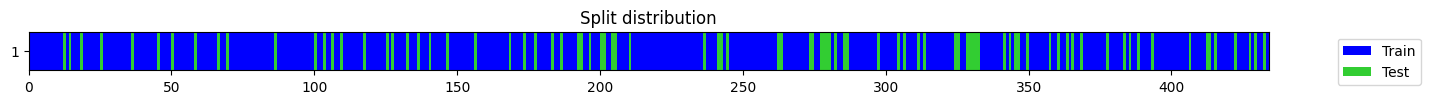

In [7]:
# %%
report_splits = get_splits(y, valid_size=0.2)
X_train, y_train = x[report_splits[0]], y[report_splits[0]]
X_test, y_test = x[report_splits[1]], y[report_splits[1]]

valid == train


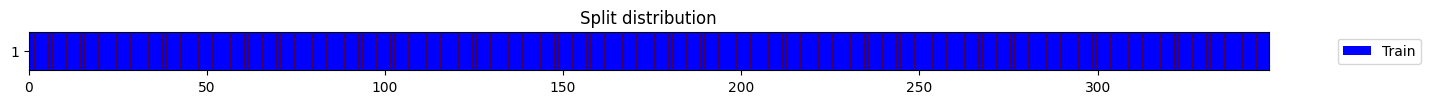

Counter({1: 205, 0: 205})

In [8]:
# %%
train_balance_splits = get_splits(y_train, valid_size=0, balance=True, strategy="oversample")
X_train, y_train = X_train[train_balance_splits[0]], y_train[train_balance_splits[0]]
Counter(y_train)

In [9]:
# %%
window_size = 4096
overlap_pct = 0.
X_train, y_train = ArrayGenerator.apply_sliding_window(ts_3d=X_train, labels=y_train, window_size=4096, overlap_pct=0.8, with_fft=True)
X_test, y_test = ArrayGenerator.apply_sliding_window(ts_3d=X_test, labels=y_test, window_size=4096, overlap_pct=0.8, with_fft=True)

In [10]:
# %%
x, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

In [11]:
# %%
tfms  = [None, [TSStandardize(by_var=True), Categorize()]]
batch_tfms = [TSStandardize(by_var=True)]
dls = get_ts_dls(x, y, splits=splits, tfms=tfms, shuffle_train=True, batch_tfms=batch_tfms, bs=[32,256])

In [12]:
model = MLP(c_in=dls.vars,c_out=dls.c,seq_len=X_train.shape[-1] , layers=[32], ps=[0.2] )
learn = Learner(dls, model, metrics=[accuracy, Precision(), Recall(), F1Score()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.453681,0.422724,0.807047,0.779126,0.930435,0.848085,00:00
1,0.280314,0.322195,0.877517,0.917178,0.866667,0.891207,00:00
2,0.189598,0.380952,0.850671,0.828205,0.936232,0.878912,00:00
3,0.137907,0.397832,0.870805,0.894118,0.881159,0.887591,00:00
4,0.092724,0.358796,0.875839,0.886040,0.901449,0.893678,00:00
5,0.071389,0.395814,0.882550,0.898551,0.898551,0.898551,00:00
6,0.049984,0.466273,0.864094,0.868715,0.901449,0.884780,00:00
7,0.051269,0.507032,0.860738,0.874286,0.886957,0.880576,00:00
8,0.037240,0.535141,0.859060,0.832061,0.947826,0.886179,00:00
9,0.028628,0.479719,0.872483,0.896755,0.881159,0.888889,00:00


,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score
14,0.015434,0.478961,0.872483,0.889855,0.889855,0.889855


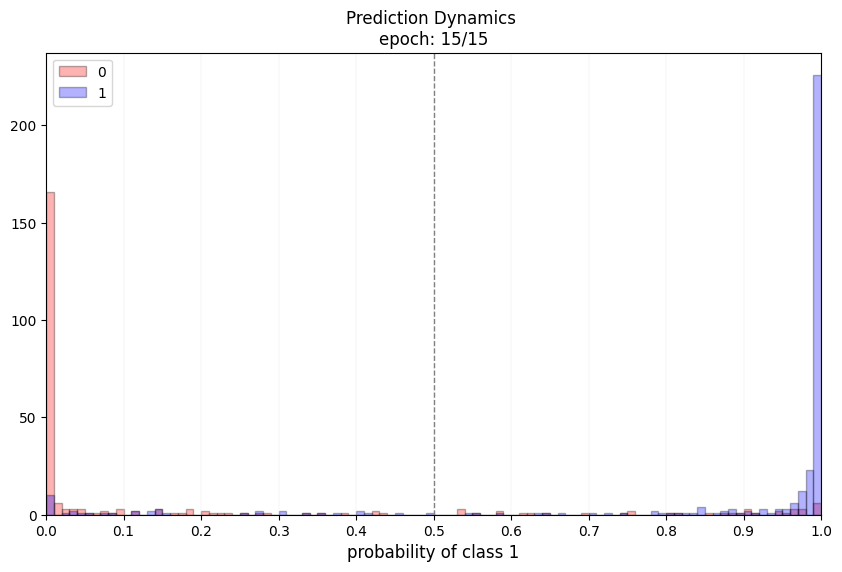

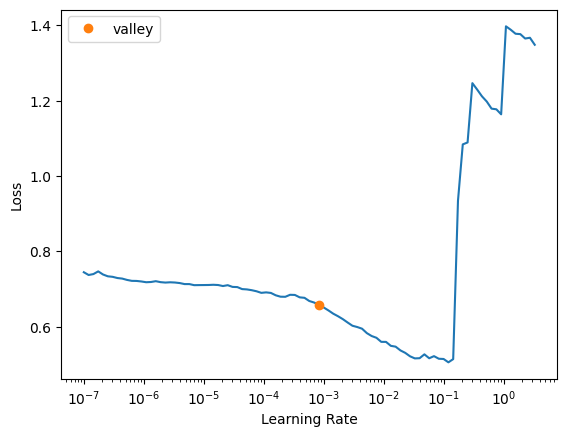

In [13]:
learn.fit_one_cycle(15, lr_max=learn.lr_find(), cbs=[PredictionDynamics()])

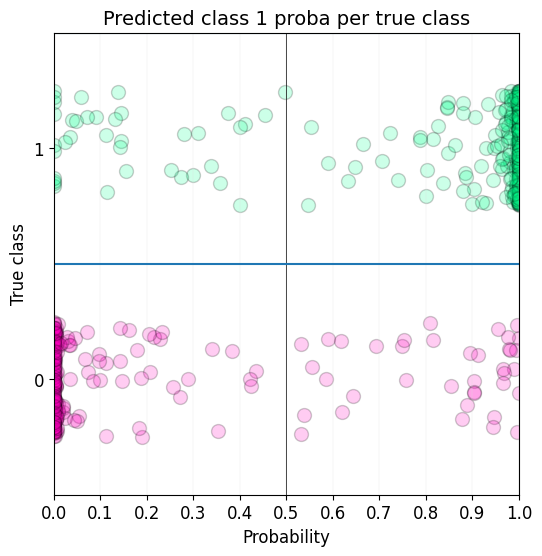

In [14]:
learn.show_probas()

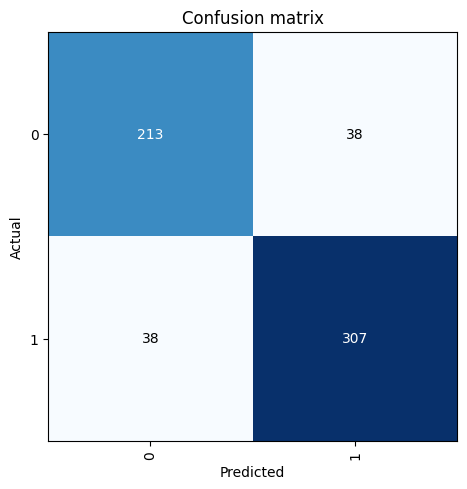

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()